# Photocell Degradation GGH Benchmark

Benchmark comparing GGH against imputation methods on the Photocell Degradation dataset.

**Methods:**
- GGH Soft Refinement (gradient-guided hypothesis selection)
- Imputation Methods: Soft Impute, Miss Forest, MICE, KNN, Hyperimpute, TabPFN
- Optional: Full Info (oracle) and Partial (baseline)

**Dataset:** Photocell PCE10 degradation dataset - predicting degradation from polymer concentrations.

In [1]:
# CUDA determinism fix (must be before torch import)
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import sys
import numpy as np
import torch
import warnings
import time

# Add parent directory to path for packages
sys.path.insert(0, '..')

# Import from GGH_2 package
from GGH_2 import (
    HypothesisAmplifyingModel,
    set_to_deterministic,
    run_ggh_soft_refinement,
    # Benchmark utilities
    run_imputation_method,
    train_ggh_model,
    train_full_info_model,
    train_partial_model,
    plot_all_metrics,
    # Save/Load results
    save_benchmark_results, load_benchmark_results,
)
from GGH_2.ggh import DEFAULT_CONFIG

# Import from GGH package
from GGH.data_ops import DataOperator

# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Data paths
data_path = '../data/dataset_photo_pce10/data.csv'
results_path = "../saved_results/Photocell Degradation_GGH_Benchmark"
os.makedirs(results_path, exist_ok=True)

# Variables for Photocell Degradation dataset
inpt_vars = ['P3HT', 'PTB7-Th']
target_vars = ['Degradation']
miss_vars = ['PCBM']

# Hypothesis values
hypothesis = [[0.03, 0.11, 0.20, 0.32, 0.43, 0.6]]
hyp_per_sample = len(hypothesis[0])

# Benchmark settings
BENCHMARK_N_RUNS = 15
PARTIAL_PERC = 0.03

# GGH hyperparameters
GGH_CONFIG = DEFAULT_CONFIG.copy()
GGH_CONFIG.update({
    'iter1_epochs': 60,
    'iter2_epochs': 30,
    'partial_base_weight': 2.0,
})

# Training parameters
FINAL_EPOCHS = 200
BENCHMARK_LR = 0.004

# Optional methods (set to True to include)
INCLUDE_FULL_INFO = False  # Oracle upper bound
INCLUDE_PARTIAL = False    # Baseline lower bound

# Imputation methods to test
IMPUTATION_METHODS = [
    "Soft Impute",
    "Miss Forest", 
    "Iterative MICE Imputer",
    "KNN Imputer",
    "Hyperimpute",
]

# Try to add TabPFN if available
try:
    from tabpfn import TabPFNClassifier
    IMPUTATION_METHODS.extend(["TabPFN", "TabPFN Regressor"])
    print("TabPFN available - included in benchmark")
except ImportError:
    print("TabPFN not available - skipping")

print(f"\nDataset: Photocell Degradation")
print(f"Input variables: {inpt_vars}")
print(f"Missing variable: {miss_vars}")
print(f"Hypothesis values: {hypothesis[0]}")
print(f"Partial percentage: {PARTIAL_PERC*100:.1f}%")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print(f"Learning rate: {BENCHMARK_LR}")
print(f"\nMethods to benchmark:")
print(f"  - GGH Soft Refinement")
for m in IMPUTATION_METHODS:
    print(f"  - {m}")
if INCLUDE_FULL_INFO:
    print(f"  - Full Info (oracle)")
if INCLUDE_PARTIAL:
    print(f"  - Partial (baseline)")

TabPFN available - included in benchmark

Dataset: Photocell Degradation
Input variables: ['P3HT', 'PTB7-Th']
Missing variable: ['PCBM']
Hypothesis values: [0.03, 0.11, 0.2, 0.32, 0.43, 0.6]
Partial percentage: 3.0%
Number of runs: 15
Learning rate: 0.004

Methods to benchmark:
  - GGH Soft Refinement
  - Soft Impute
  - Miss Forest
  - Iterative MICE Imputer
  - KNN Imputer
  - Hyperimpute
  - TabPFN
  - TabPFN Regressor


In [3]:
# =============================================================================
# MAIN BENCHMARK
# =============================================================================

print("=" * 80)
print("PHOTOCELL BENCHMARK: GGH vs Imputation Methods")
print("=" * 80)

# Initialize results storage for all metrics
results_r2 = {'GGH': []}
results_mse = {'GGH': []}
results_mae = {'GGH': []}

for method in IMPUTATION_METHODS:
    results_r2[method] = []
    results_mse[method] = []
    results_mae[method] = []

if INCLUDE_FULL_INFO:
    results_r2['Full Info'] = []
    results_mse['Full Info'] = []
    results_mae['Full Info'] = []

if INCLUDE_PARTIAL:
    results_r2['Partial'] = []
    results_mse['Partial'] = []
    results_mae['Partial'] = []

# Track timing
timings = {k: [] for k in results_r2.keys()}

# Find valid random states
valid_r_states = []
for r_state in range(2000):
    if len(valid_r_states) >= BENCHMARK_N_RUNS:
        break
    set_to_deterministic(r_state)
    DO_test = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                           PARTIAL_PERC, r_state, device=DEVICE)
    if not DO_test.lack_partial_coverage:
        valid_r_states.append(r_state)

print(f"\nUsing random states: {valid_r_states}")
print(f"\n{'='*80}")

# Run benchmark
for run_idx, r_state in enumerate(valid_r_states):
    print(f"\n--- Run {run_idx + 1}/{BENCHMARK_N_RUNS} (r_state={r_state}) ---")
    
    set_to_deterministic(r_state)
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      PARTIAL_PERC, r_state, device=DEVICE)
    
    partial_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) &
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_partial = len(partial_gids)
    print(f"    Partial samples: {n_partial}")
    
    # === GGH ===
    print("    Running GGH...", end=" ", flush=True)
    start = time.time()
    ggh_weights, ggh_precision, _, ggh_partial_weight = run_ggh_soft_refinement(DO, r_state, GGH_CONFIG)
    ggh_mse, ggh_mae, ggh_r2 = train_ggh_model(DO, ggh_weights, partial_gids, ggh_partial_weight, r_state,
                                                 GGH_CONFIG, BENCHMARK_LR, FINAL_EPOCHS, DEVICE)
    ggh_time = time.time() - start
    results_r2['GGH'].append(ggh_r2)
    results_mse['GGH'].append(ggh_mse)
    results_mae['GGH'].append(ggh_mae)
    timings['GGH'].append(ggh_time)
    print(f"R2={ggh_r2:.4f} MSE={ggh_mse:.4f} MAE={ggh_mae:.4f} ({ggh_time:.1f}s)")
    
    # === Imputation Methods ===
    for method in IMPUTATION_METHODS:
        print(f"    Running {method}...", end=" ", flush=True)
        start = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            metrics, error = run_imputation_method(DO, method, r_state, hypothesis, BENCHMARK_LR, FINAL_EPOCHS)
        method_time = time.time() - start
        
        if metrics is not None:
            mse, mae, r2 = metrics
            results_r2[method].append(r2)
            results_mse[method].append(mse)
            results_mae[method].append(mae)
            timings[method].append(method_time)
            print(f"R2={r2:.4f} MSE={mse:.4f} MAE={mae:.4f} ({method_time:.1f}s)")
        else:
            print(f"FAILED: {error}")
    
    # === Optional: Full Info ===
    if INCLUDE_FULL_INFO:
        print("    Running Full Info...", end=" ", flush=True)
        start = time.time()
        full_mse, full_mae, full_r2 = train_full_info_model(DO, r_state, GGH_CONFIG, BENCHMARK_LR, FINAL_EPOCHS, DEVICE)
        full_time = time.time() - start
        results_r2['Full Info'].append(full_r2)
        results_mse['Full Info'].append(full_mse)
        results_mae['Full Info'].append(full_mae)
        timings['Full Info'].append(full_time)
        print(f"R2={full_r2:.4f} MSE={full_mse:.4f} MAE={full_mae:.4f} ({full_time:.1f}s)")
    
    # === Optional: Partial Only ===
    if INCLUDE_PARTIAL:
        print("    Running Partial...", end=" ", flush=True)
        start = time.time()
        partial_mse, partial_mae, partial_r2 = train_partial_model(DO, partial_gids, r_state, GGH_CONFIG, BENCHMARK_LR, FINAL_EPOCHS, DEVICE)
        partial_time = time.time() - start
        results_r2['Partial'].append(partial_r2)
        results_mse['Partial'].append(partial_mse)
        results_mae['Partial'].append(partial_mae)
        timings['Partial'].append(partial_time)
        print(f"R2={partial_r2:.4f} MSE={partial_mse:.4f} MAE={partial_mae:.4f} ({partial_time:.1f}s)")

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")

# Save results to disk
save_benchmark_results(results_r2, results_mse, results_mae, "Photocell Degradation",
                       results_path, timings=timings, valid_r_states=valid_r_states)

PHOTOCELL BENCHMARK: GGH vs Imputation Methods

Using random states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16]


--- Run 1/15 (r_state=0) ---
    Partial samples: 22
    Running GGH... R2=0.3447 MSE=0.0072 MAE=0.0642 (80.3s)
    Running Soft Impute... R2=-0.9833 MSE=0.0219 MAE=0.1106 (4.6s)
    Running Miss Forest... R2=-0.2272 MSE=0.0135 MAE=0.0820 (2.8s)
    Running Iterative MICE Imputer... R2=-3.0369 MSE=0.0445 MAE=0.1544 (2.7s)
    Running KNN Imputer... R2=0.1790 MSE=0.0091 MAE=0.0673 (2.7s)
    Running Hyperimpute... R2=0.1746 MSE=0.0091 MAE=0.0676 (23.8s)
    Running TabPFN... R2=-0.9890 MSE=0.0219 MAE=0.1019 (22.0s)
    Running TabPFN Regressor... R2=-1.6303 MSE=0.0290 MAE=0.1140 (9.2s)

--- Run 2/15 (r_state=1) ---
    Partial samples: 22
    Running GGH... R2=0.4085 MSE=0.0066 MAE=0.0629 (76.8s)
    Running Soft Impute... R2=-1.4013 MSE=0.0269 MAE=0.1306 (2.7s)
    Running Miss Forest... R2=-0.1714 MSE=0.0131 MAE=0.0834 (2.8s)
    Running Iterative MICE Imputer... R

'../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_results_2026-02-10.json'

In [4]:
# =============================================================================
# LOAD RESULTS (use this cell instead of running the benchmark above)
# =============================================================================
# Uncomment and set the path to load previously saved results:
#
results_r2, results_mse, results_mae, metadata = load_benchmark_results(
    results_path + "/Photocell_Degradation_results_2026-02-10.json"
)
timings = metadata.get('timings', {})
valid_r_states = metadata.get('valid_r_states', [])

Loaded results: Photocell Degradation (2026-02-10 15:16:53)
  15 runs, 8 methods: ['GGH', 'Soft Impute', 'Miss Forest', 'Iterative MICE Imputer', 'KNN Imputer', 'Hyperimpute', 'TabPFN', 'TabPFN Regressor']


In [5]:
# =============================================================================
# RESULTS SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("BENCHMARK RESULTS SUMMARY")
print("=" * 80)
print(f"{'Method':<25} | {'Mean R2':>10} | {'Mean MSE':>10} | {'Mean MAE':>10} | {'Avg Time':>10}")
print("-" * 85)

# Sort methods by mean R2 (descending)
method_means_r2 = []
for method, r2_list in results_r2.items():
    if r2_list:
        mean_r2 = np.mean(r2_list)
        method_means_r2.append((method, mean_r2))

method_means_r2.sort(key=lambda x: x[1], reverse=True)

for method, _ in method_means_r2:
    r2_list = results_r2[method]
    mse_list = results_mse[method]
    mae_list = results_mae[method]
    time_list = timings[method]
    
    mean_r2 = np.mean(r2_list)
    mean_mse = np.mean(mse_list)
    mean_mae = np.mean(mae_list)
    avg_time = np.mean(time_list) if time_list else 0
    
    print(f"{method:<25} | {mean_r2:>10.4f} | {mean_mse:>10.4f} | {mean_mae:>10.4f} | {avg_time:>9.1f}s")

print("=" * 85)

# Highlight best method
if method_means_r2:
    best_method = method_means_r2[0][0]
    best_r2 = method_means_r2[0][1]
    print(f"\nBest method (by R2): {best_method} (Mean R2 = {best_r2:.4f})")
    
    # Compare GGH to imputation methods
    ggh_r2 = np.mean(results_r2['GGH']) if results_r2['GGH'] else 0
    ggh_mse = np.mean(results_mse['GGH']) if results_mse['GGH'] else 0
    ggh_mae = np.mean(results_mae['GGH']) if results_mae['GGH'] else 0
    
    imputation_means = [(m, np.mean(results_r2[m])) for m in IMPUTATION_METHODS if results_r2[m]]
    
    if imputation_means:
        best_imputation = max(imputation_means, key=lambda x: x[1])
        best_imp_method = best_imputation[0]
        print(f"\nGGH vs Best Imputation ({best_imp_method}):")
        print(f"  Metric    | GGH       | {best_imp_method:<15} | Difference")
        print(f"  R2        | {ggh_r2:>9.4f} | {best_imputation[1]:>15.4f} | {(ggh_r2 - best_imputation[1]):>+10.4f}")
        print(f"  MSE       | {ggh_mse:>9.4f} | {np.mean(results_mse[best_imp_method]):>15.4f} | {(ggh_mse - np.mean(results_mse[best_imp_method])):>+10.4f}")
        print(f"  MAE       | {ggh_mae:>9.4f} | {np.mean(results_mae[best_imp_method]):>15.4f} | {(ggh_mae - np.mean(results_mae[best_imp_method])):>+10.4f}")


BENCHMARK RESULTS SUMMARY
Method                    |    Mean R2 |   Mean MSE |   Mean MAE |   Avg Time
-------------------------------------------------------------------------------------
GGH                       |     0.4561 |     0.0064 |     0.0596 |      78.1s
KNN Imputer               |    -0.1282 |     0.0143 |     0.0770 |       2.8s
TabPFN                    |    -0.2818 |     0.0147 |     0.0804 |      21.5s
Miss Forest               |    -0.2829 |     0.0153 |     0.0880 |       2.8s
Hyperimpute               |    -0.3669 |     0.0163 |     0.0883 |      26.0s
Soft Impute               |    -1.4935 |     0.0287 |     0.1118 |       2.8s
Iterative MICE Imputer    |    -1.9508 |     0.0343 |     0.1182 |       2.7s
TabPFN Regressor          |    -2.2167 |     0.0374 |     0.1162 |       9.2s

Best method (by R2): GGH (Mean R2 = 0.4561)

GGH vs Best Imputation (KNN Imputer):
  Metric    | GGH       | KNN Imputer     | Difference
  R2        |    0.4561 |         -0.1282 |   

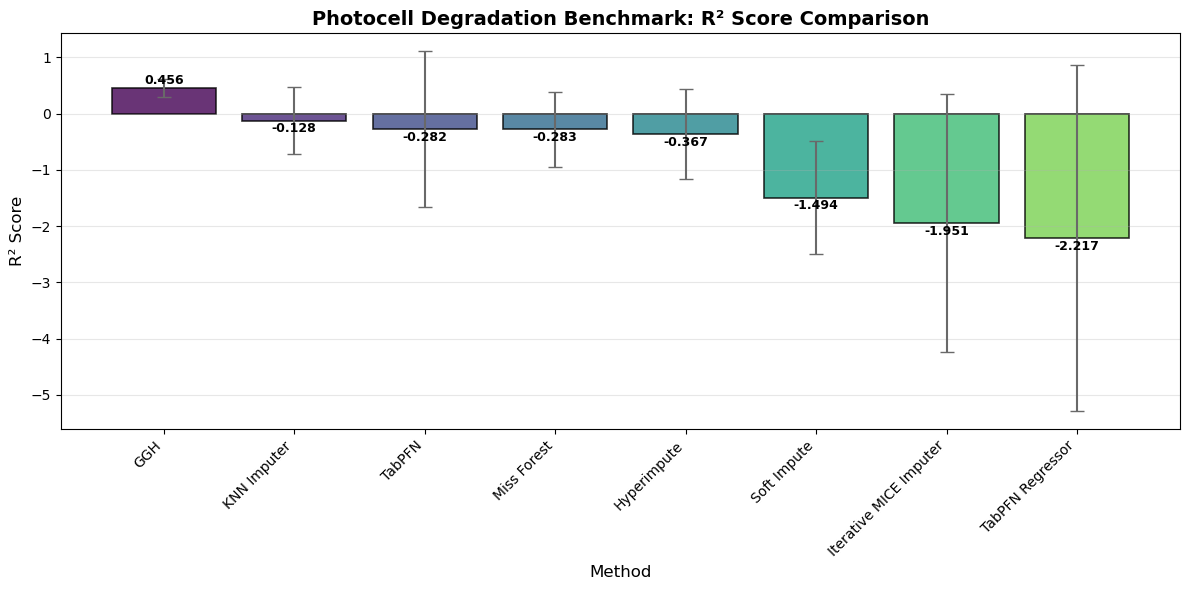

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_r2_2026-02-10.png


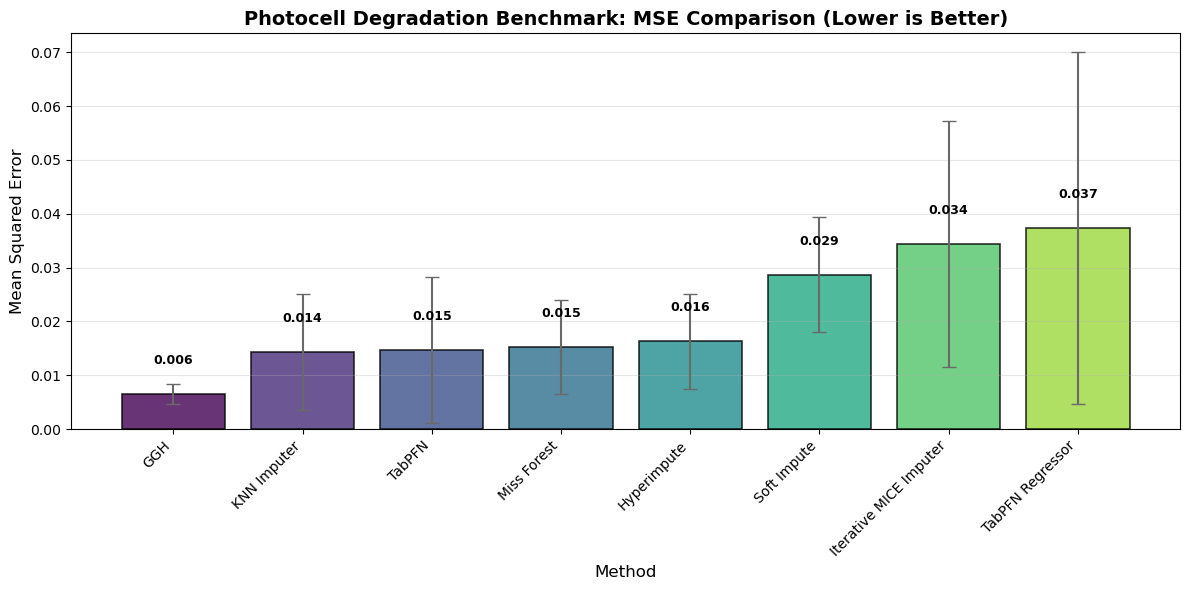

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_mse_2026-02-10.png


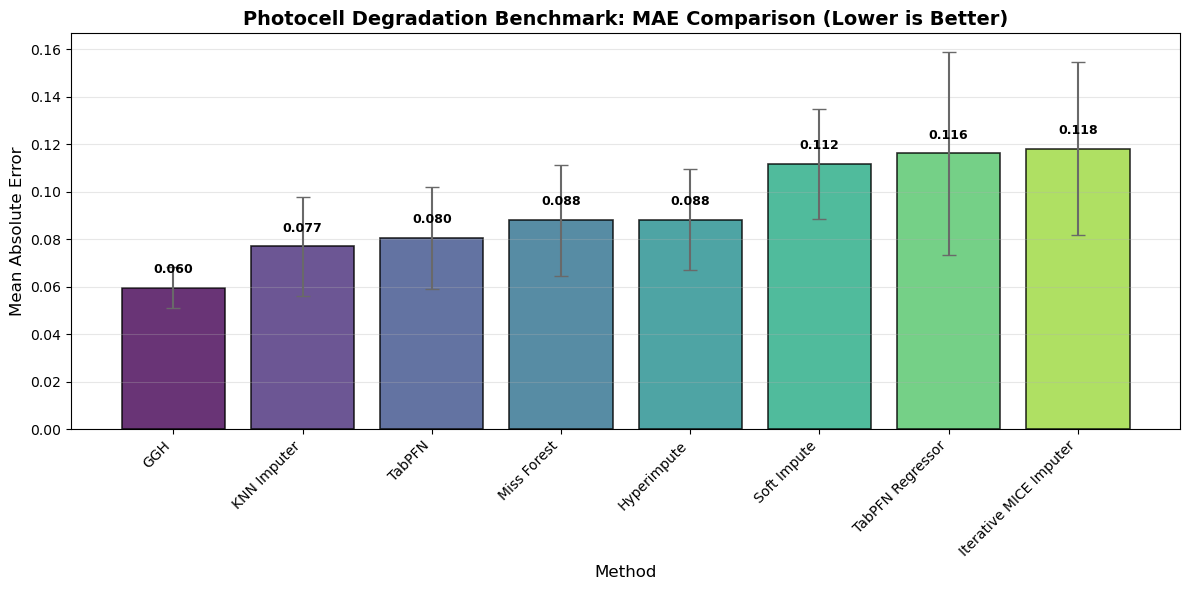

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_mae_2026-02-10.png


In [6]:
# =============================================================================
# VISUALIZATION: ALL METRICS
# =============================================================================

# Plot R², MSE, and MAE comparisons
plot_all_metrics(results_r2, results_mse, results_mae, "Photocell Degradation", results_path)

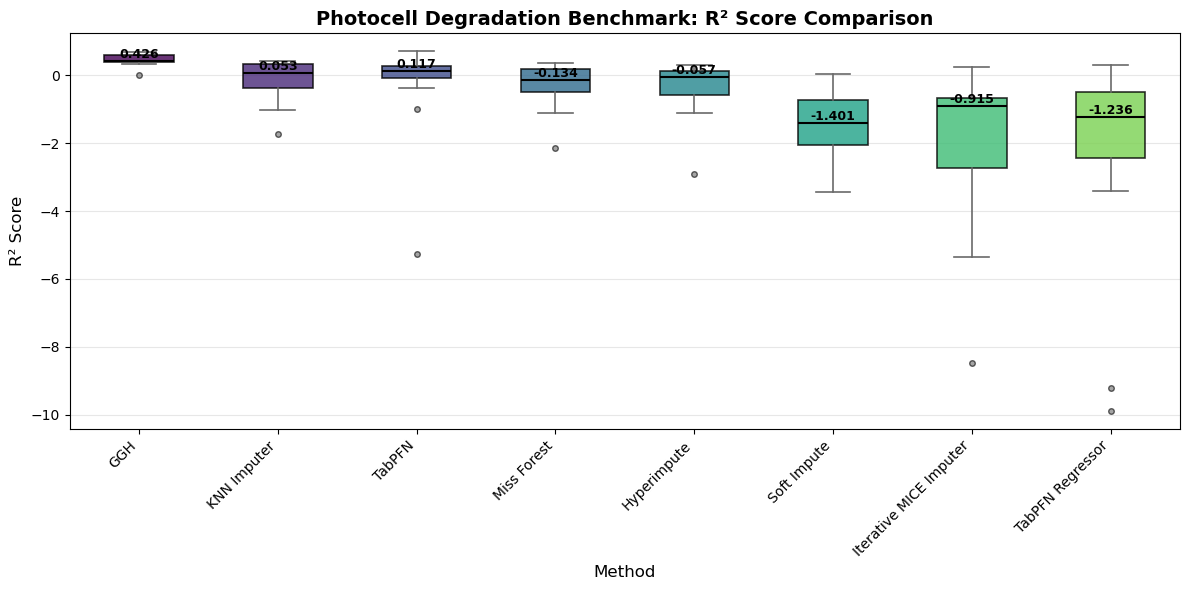

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_r2_boxplot_2026-02-10.png


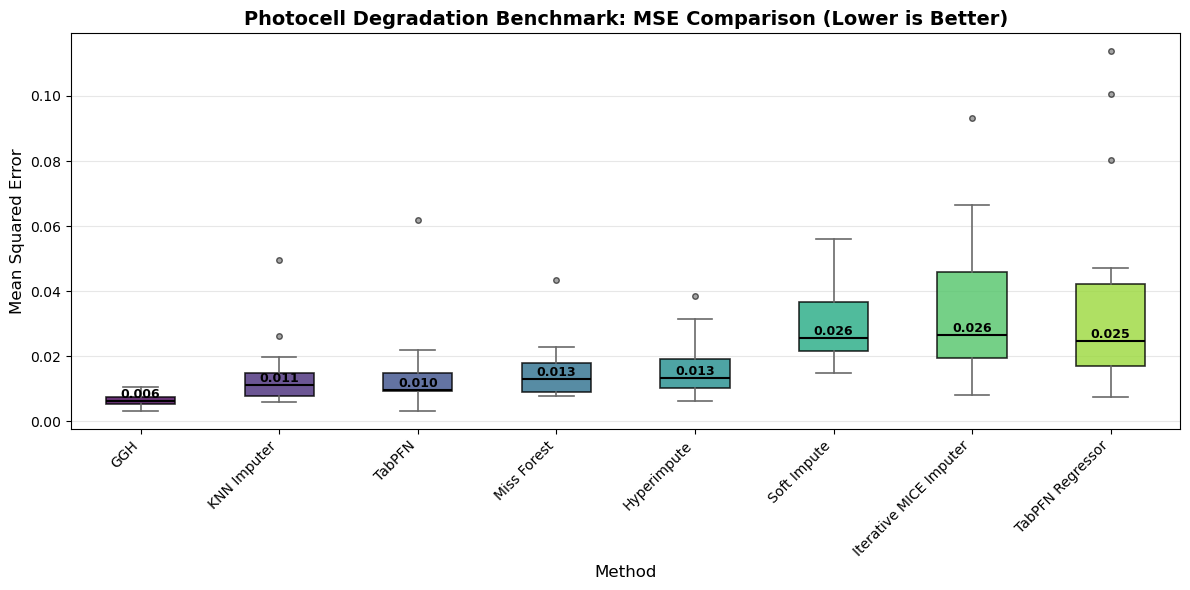

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_mse_boxplot_2026-02-10.png


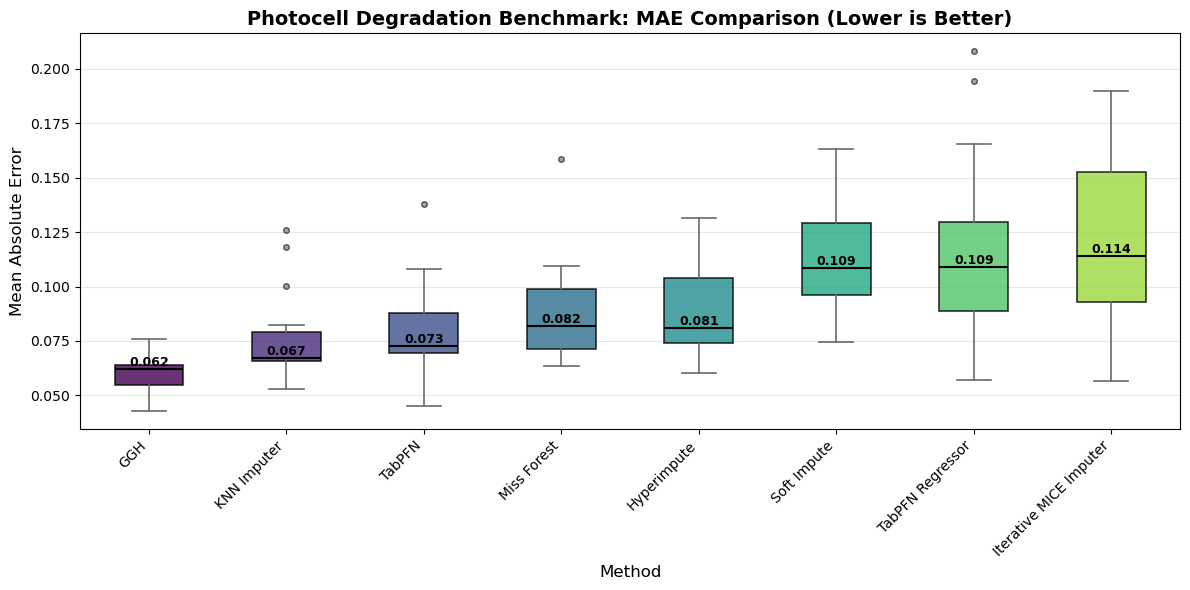

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_mae_boxplot_2026-02-10.png


In [7]:
plot_all_metrics(results_r2, results_mse, results_mae, "Photocell Degradation", results_path, plot_type="box")

## Weight Distribution Visualization

Visualize GGH V2 soft weight distributions for correct vs incorrect hypotheses.
This is the GGH V2 equivalent of the old `selection_histograms` — instead of
discrete selection counts, we show the continuous weight values assigned to each hypothesis.

Plot saved to: ../saved_results/Photocell Degradation_GGH_Benchmark/Photocell_Degradation_weight_distributions_2026-02-10.png


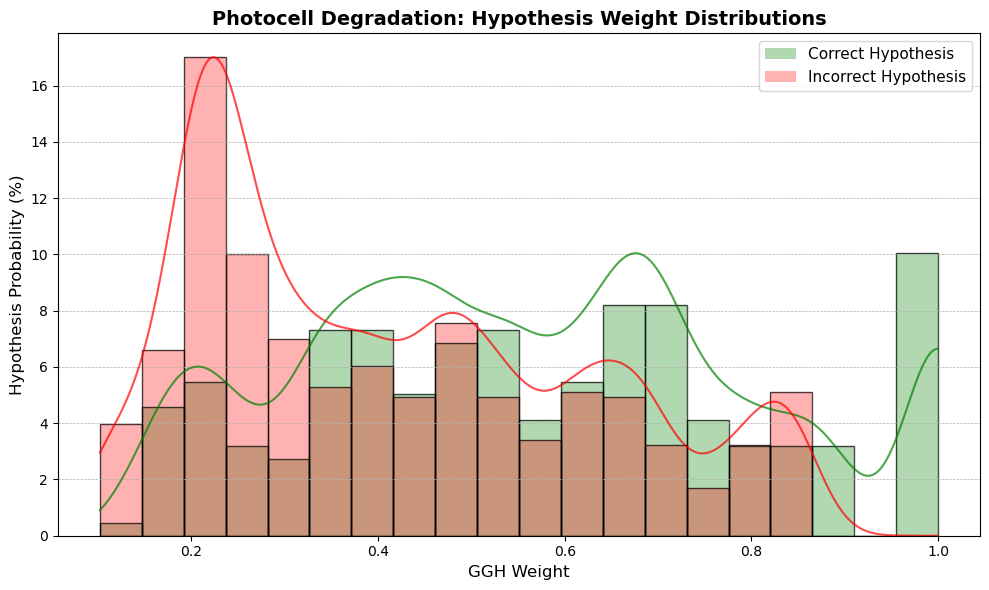

In [5]:
# =============================================================================
# WEIGHT DISTRIBUTION: Correct vs Incorrect Hypotheses
# =============================================================================
from GGH_2.benchmark_viz import plot_weight_distributions

# Run GGH on a single r_state to get weights for visualization
r_state_viz = valid_r_states[0]
set_to_deterministic(r_state_viz)
DO_viz = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                      PARTIAL_PERC, r_state_viz, device=DEVICE)

ggh_weights_viz, _, _, _ = run_ggh_soft_refinement(DO_viz, r_state_viz, GGH_CONFIG)

plot_weight_distributions(ggh_weights_viz, DO_viz,
                          dataset_name='Photocell Degradation',
                          results_path=results_path)